In [6]:
# Load grid search results
import os
from pathlib import Path
import pandas as pd

from plotnine import (
    ggplot, aes, geom_boxplot, geom_bar, geom_errorbar,
    facet_wrap, labs, ggtitle, theme_bw, theme, element_text,
    scale_fill_manual, position_dodge
)

# Load grid search results if they exist
base_dir = Path("/home/kkumbier/maps/template_analyses/multimarker_binary")
grid_results_file = base_dir / "binary_stability.csv"
grid_predictions_file = base_dir / "binary_predictions.csv"

if os.path.exists(grid_results_file) and os.path.exists(grid_predictions_file):
    grid_results = pd.read_csv(grid_results_file)
    grid_predictions = pd.read_csv(grid_predictions_file)
    
    print(f"Grid search results shape: {grid_results.shape}")
    print(f"Grid search predictions shape: {grid_predictions.shape}")
    
    # Display first few rows
    print("\nGrid Results Sample:")
    print(grid_results.head())
    
    print("\nGrid Predictions Sample:")
    print(grid_predictions.head())
    
else:
    print("Grid search files not found")
    grid_results = None
    grid_predictions = None
    
grid_results['group'] = grid_results['group'].replace({
    'agg': 'patient-level regression',
    'entropy': 'weighted average'
})

Grid search results shape: (4800, 8)
Grid search predictions shape: (12800, 15)

Grid Results Sample:
   replicate    group         metric     value  random_seed  n_layers  \
0          1      agg       accuracy  0.718750            0         0   
1          1      agg  cross_entropy  0.757162            0         0   
2          1      agg            auc  0.780392            0         0   
3          1  entropy       accuracy  0.750000            0         0   
4          1  entropy  cross_entropy  0.539114            0         0   

   d_model  use_contrastive_loss  
0       16                 False  
1       16                 False  
2       16                 False  
3       16                 False  
4       16                 False  

Grid Predictions Sample:
   class_0_agg  class_1_agg  class_0_entropy  class_1_entropy  \
0     0.707385     0.292615         0.618493         0.381507   
1     0.228309     0.771691         0.431447         0.568553   
2     0.743441     0.256559 

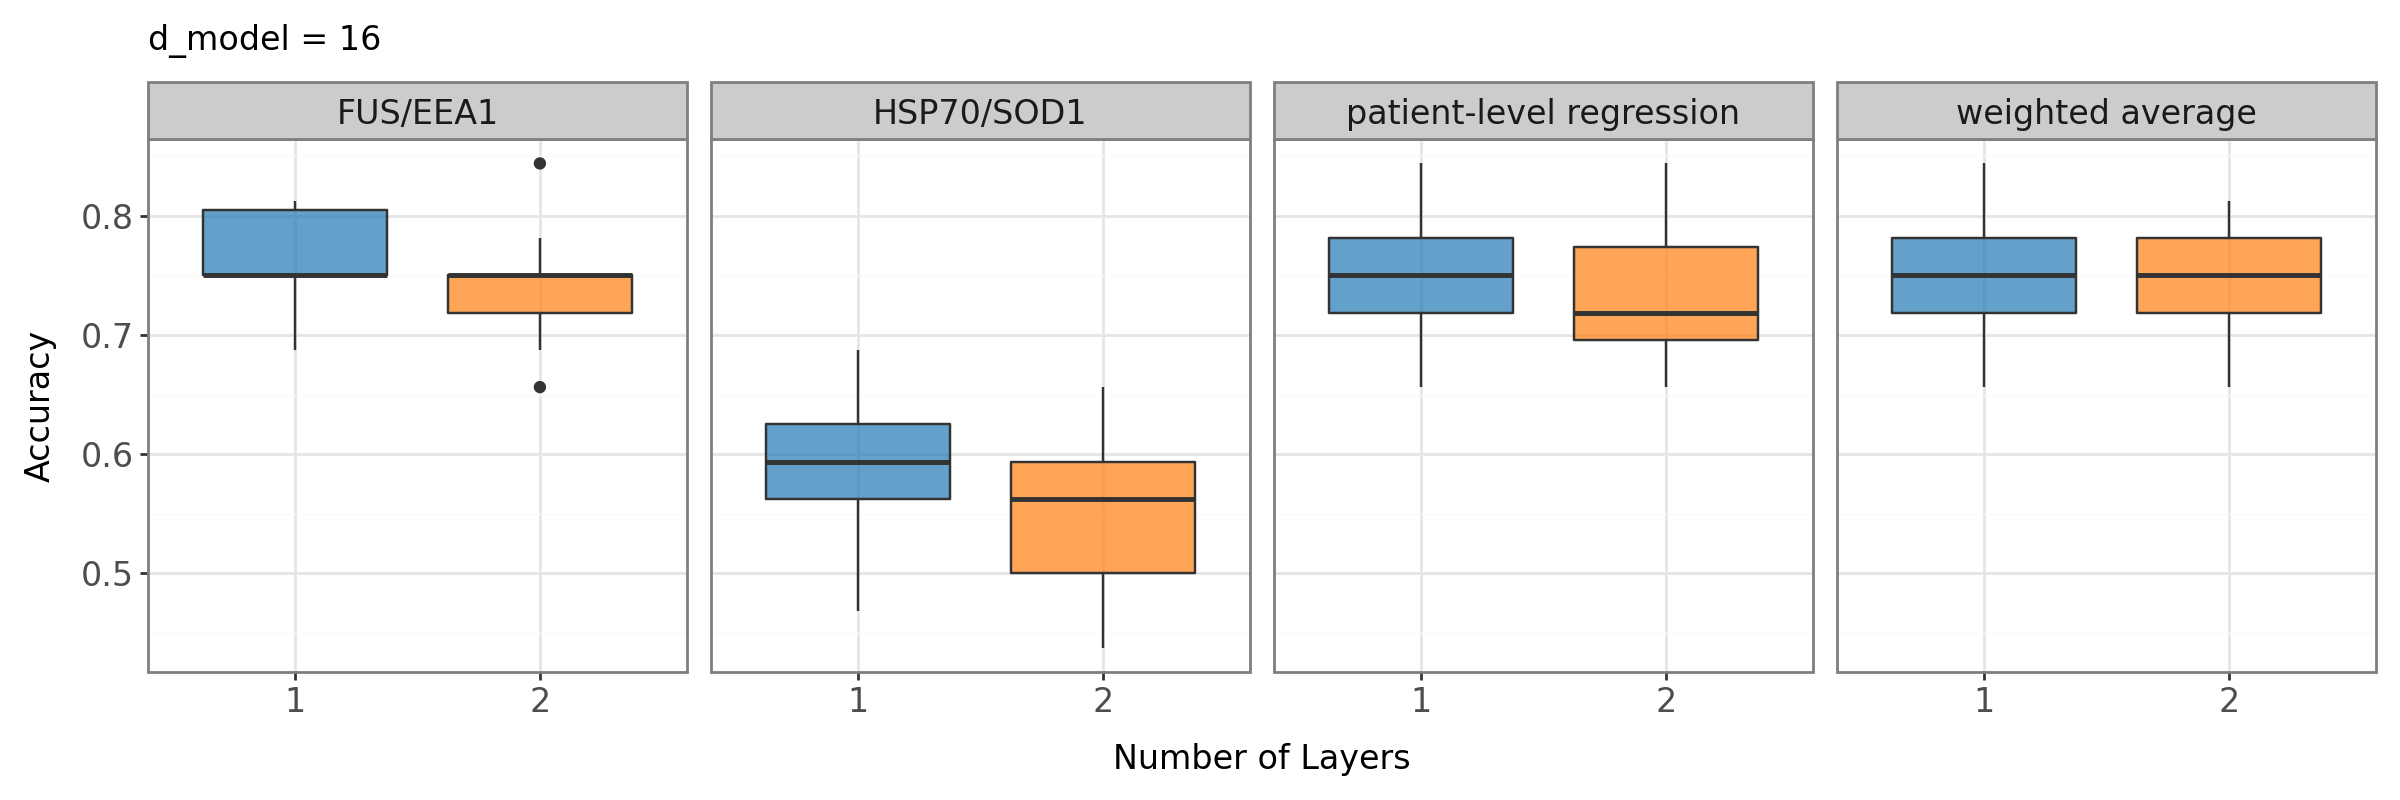

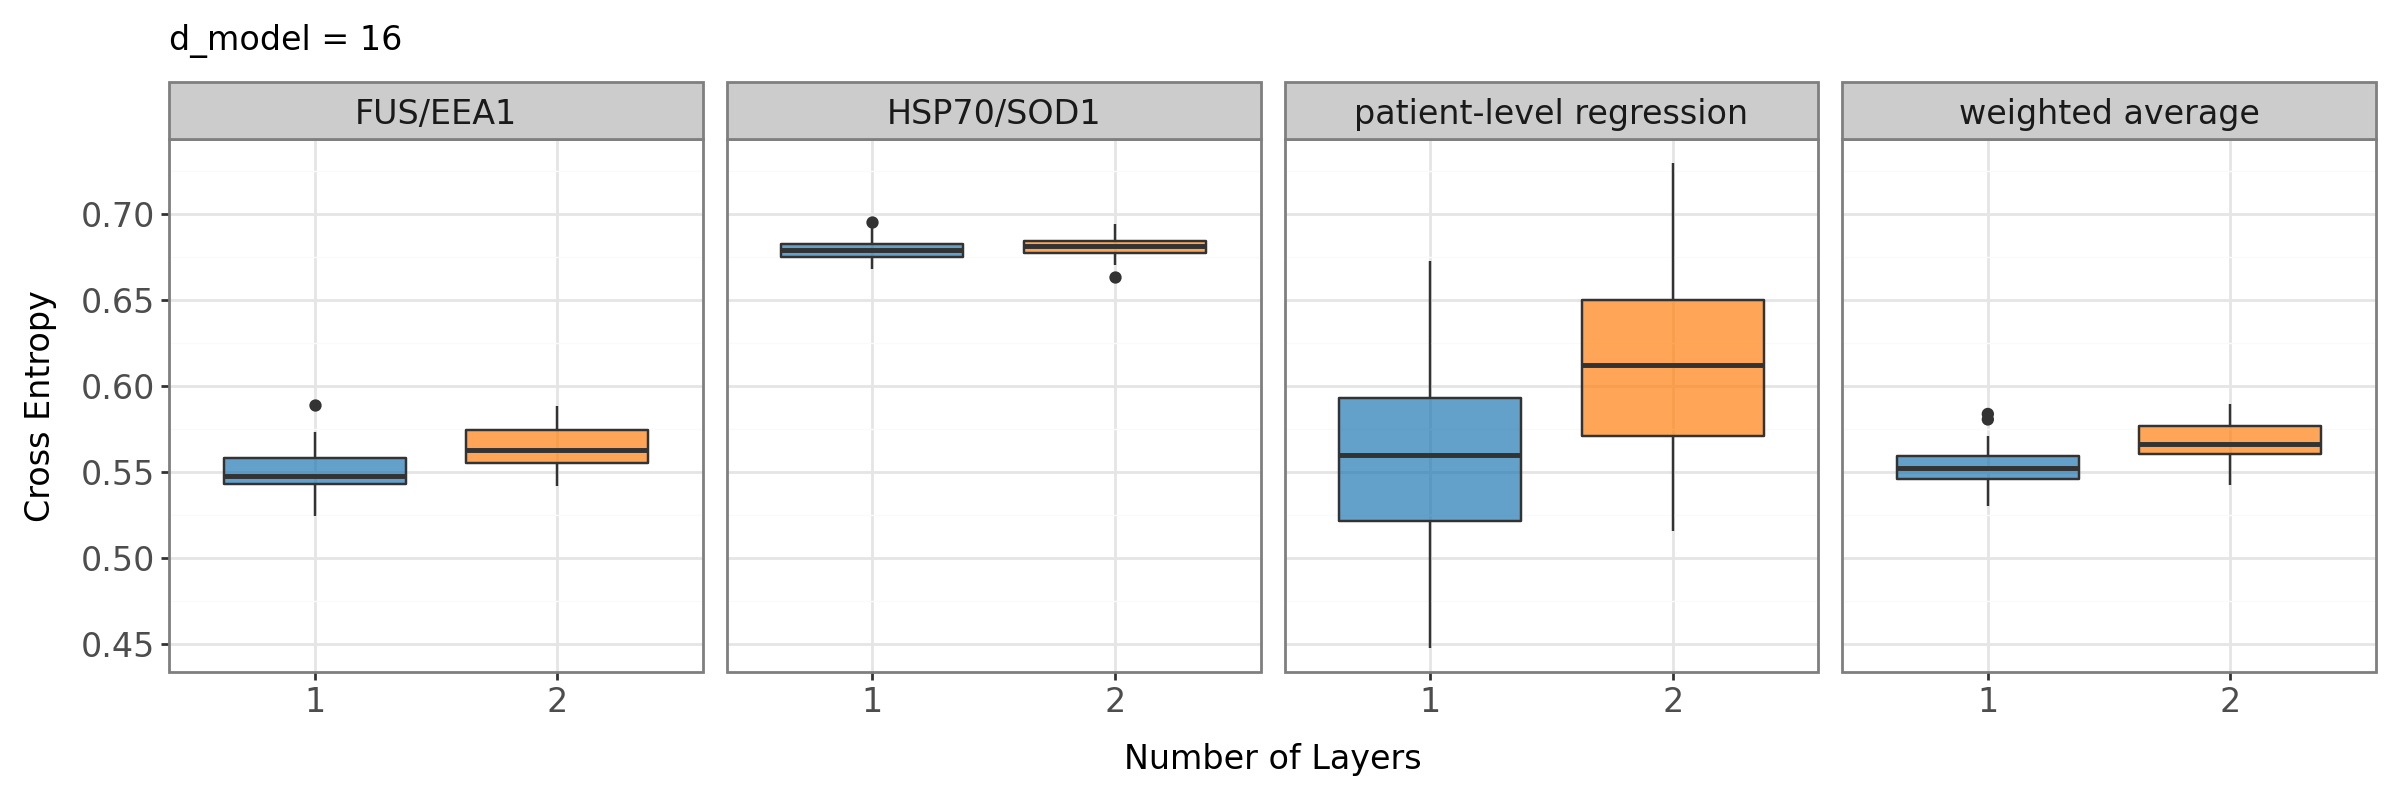

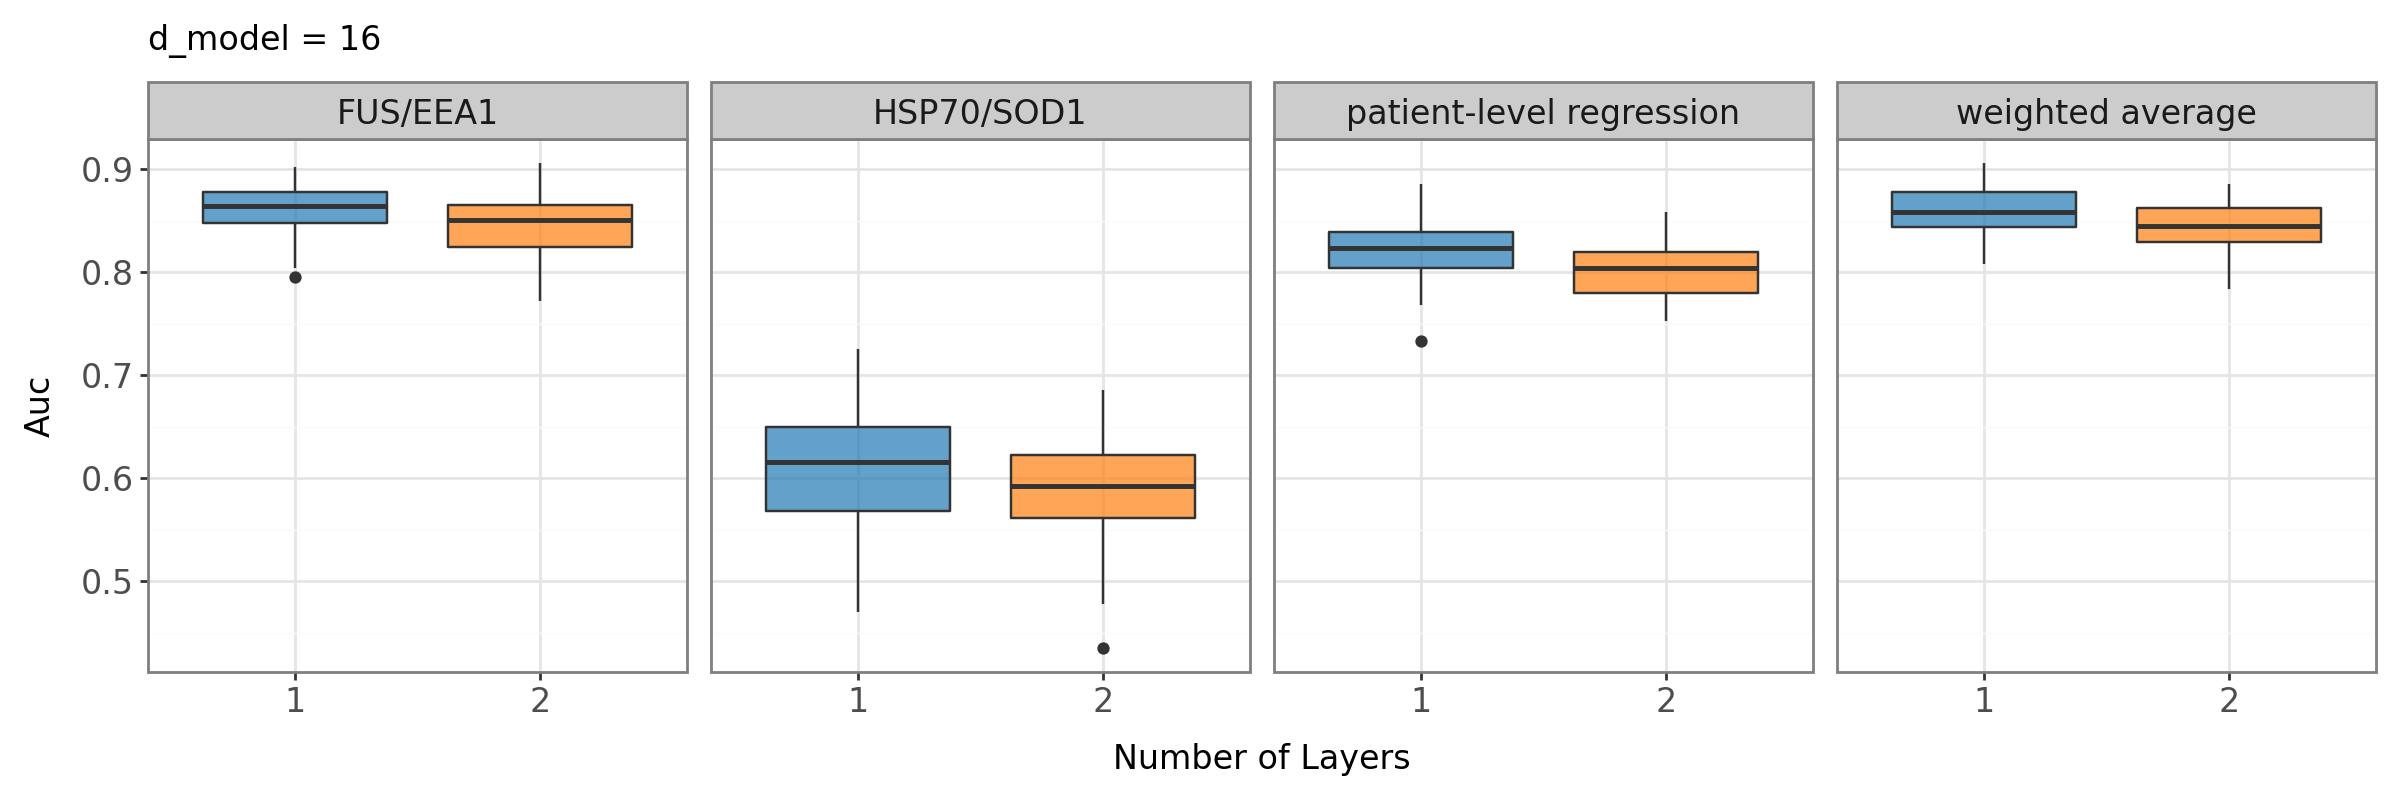

In [7]:
## Performance by Model Depth (n_layers)
# Create plots comparing metrics by n_layers (filtered to d_model = 16)
for metric in ['accuracy', 'cross_entropy', 'auc']:
    metric_data = grid_results[(grid_results['metric'] == metric) & (grid_results['d_model'] == 16)]

    metric_data = metric_data[metric_data["n_layers"] != 0]    
    metric_data = metric_data[~metric_data["use_contrastive_loss"]]

    p = (
        ggplot(metric_data, aes(x='factor(n_layers)', y='value', fill='factor(n_layers)')) +
        geom_boxplot(alpha=0.7) +
        facet_wrap('~group', nrow=1) +
        labs(x='Number of Layers', y=metric.replace('_', ' ').title(), fill='Layers',
             subtitle='d_model = 16') +
        scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c']) +
        theme_bw() +
        theme(
            axis_text_x=element_text(rotation=0), 
            legend_position="none", 
            text=element_text(size=12),
            figure_size=(12, 4)
            )
    )
    display(p)

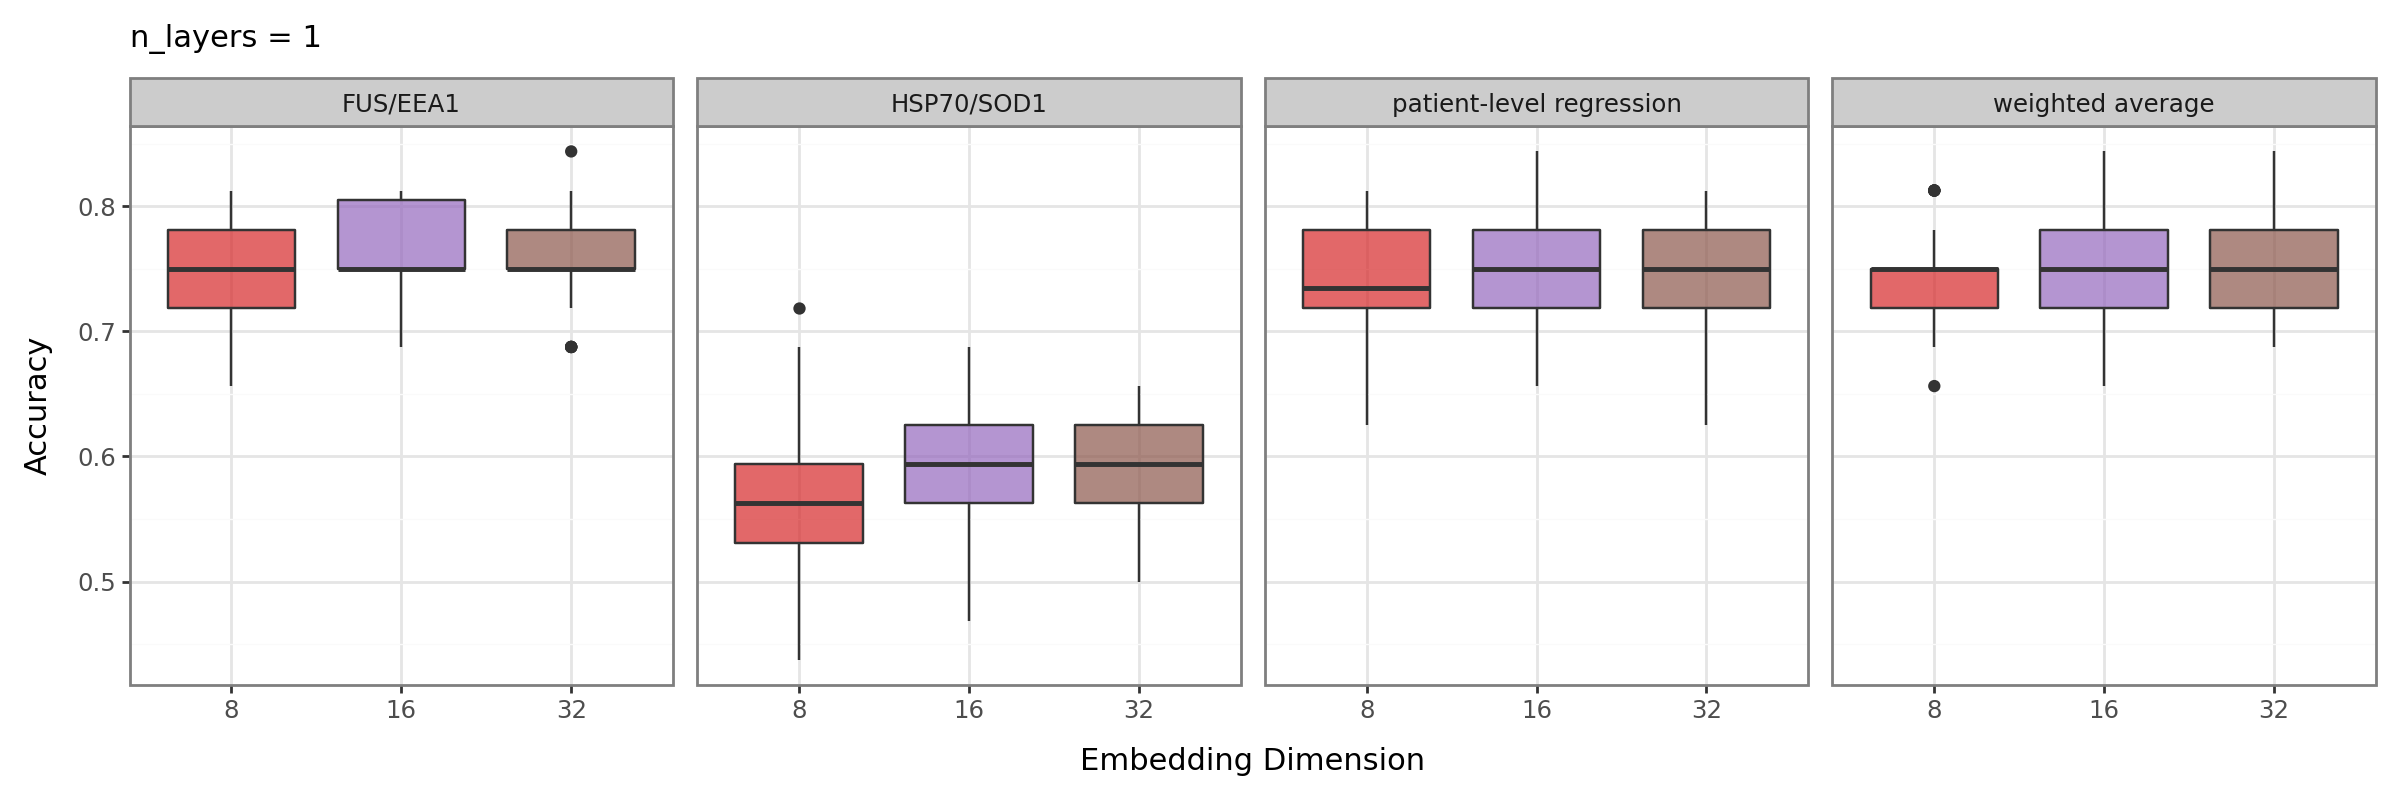

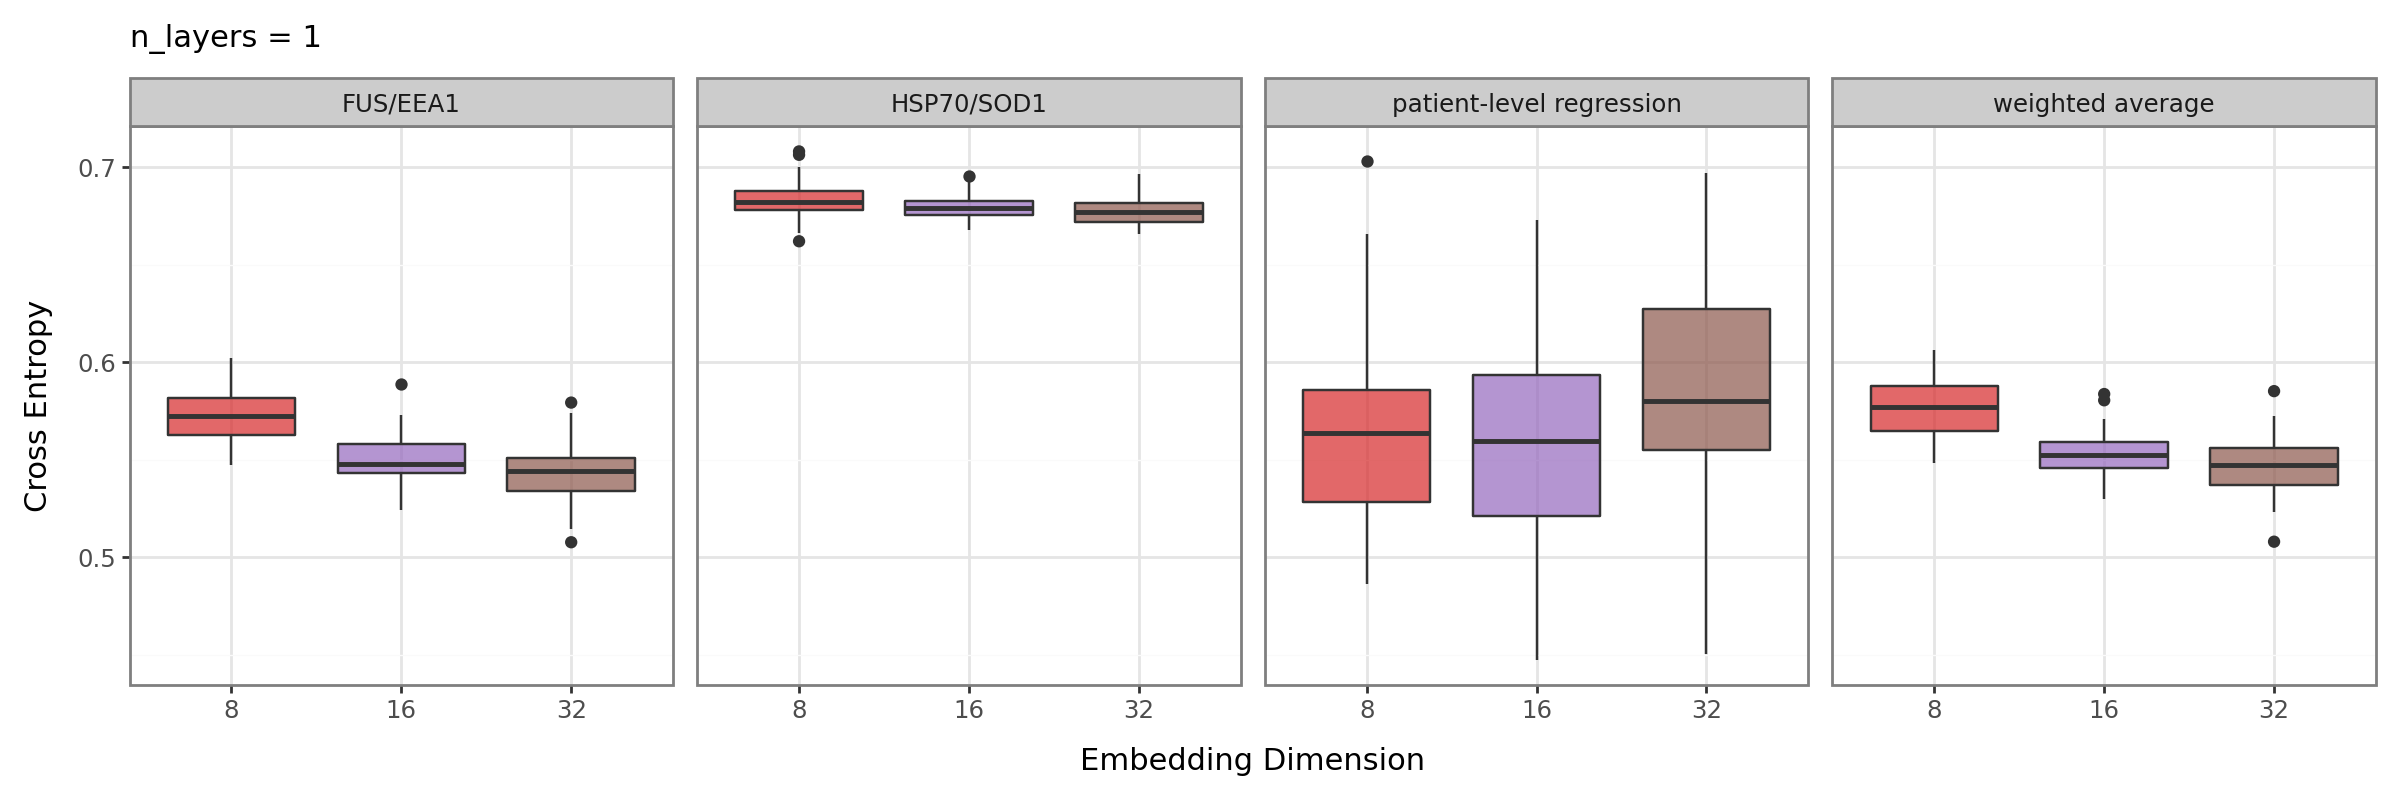

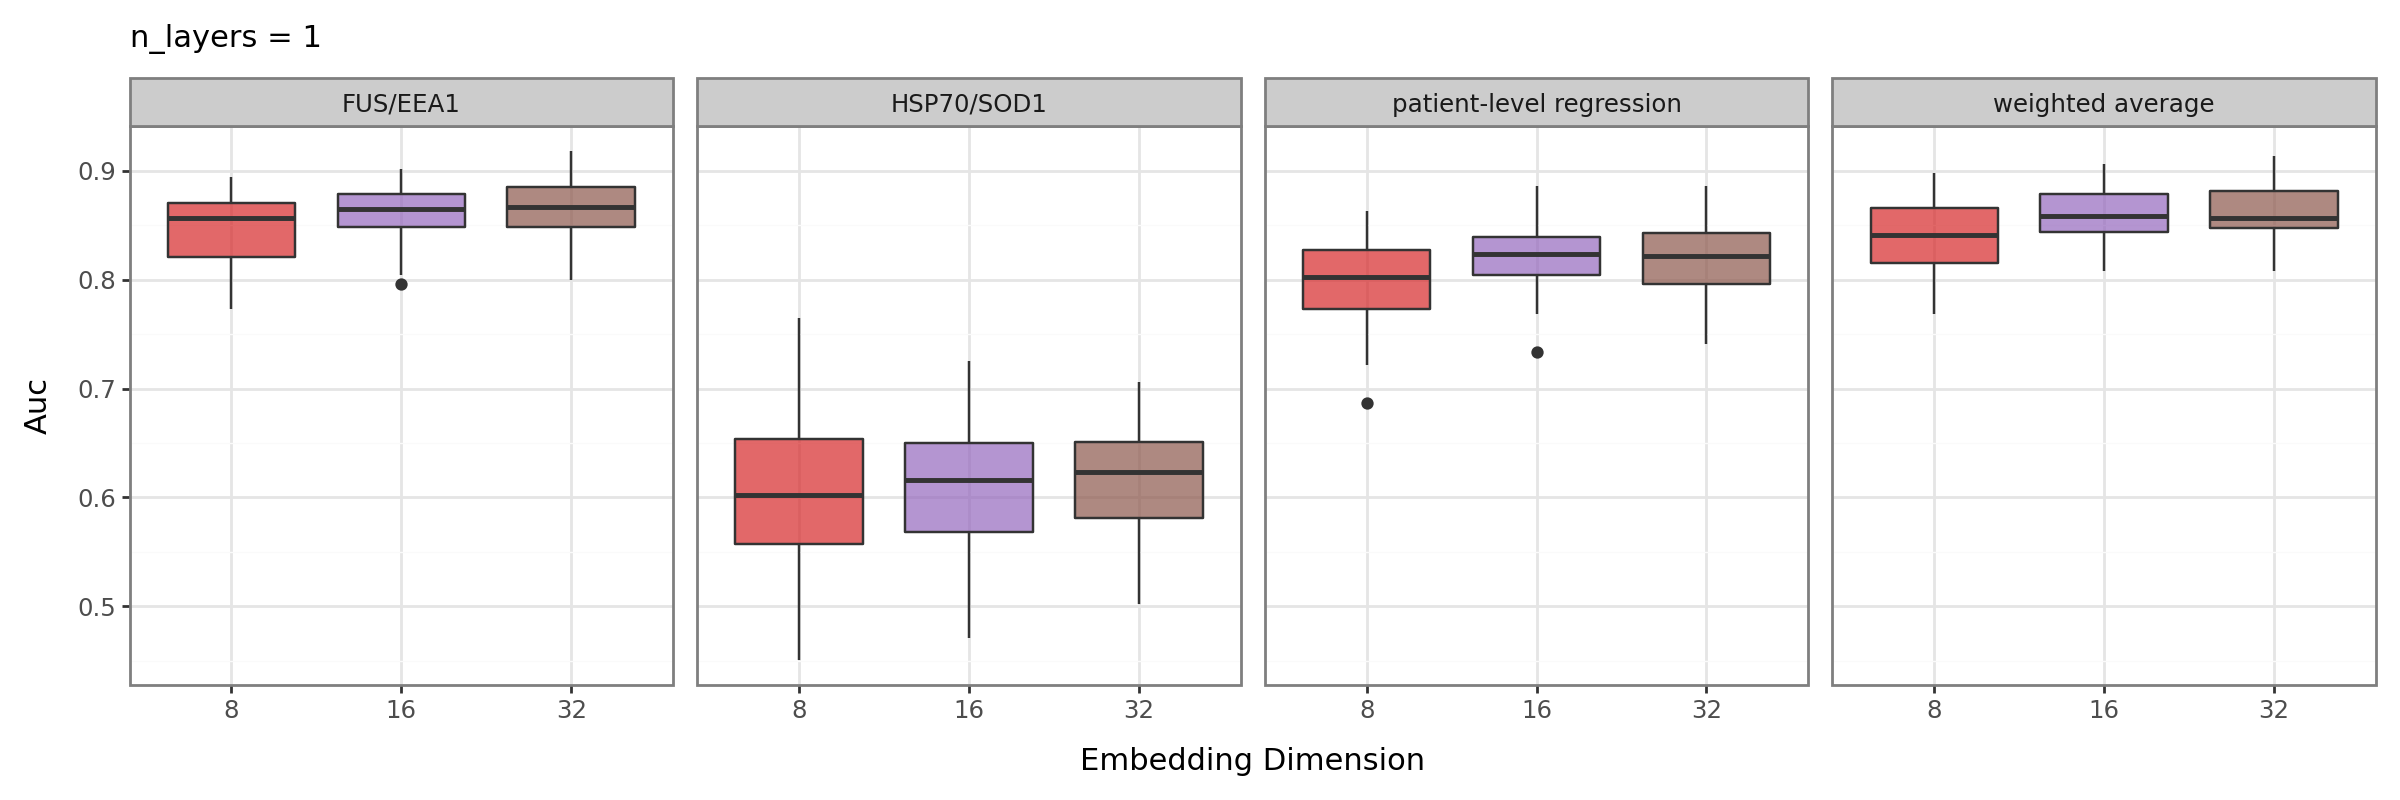

In [8]:
## Performance by Embedding Dimension (d_model)

if grid_results is not None:
    # Create plots comparing metrics by d_model (filtered to n_layers = 1)
    for metric in ['accuracy', 'cross_entropy', 'auc']:
        metric_data = grid_results[(grid_results['metric'] == metric) & (grid_results['n_layers'] == 1)]
        
        metric_data = metric_data[~metric_data["use_contrastive_loss"]]
        
        p = (
            ggplot(metric_data, aes(x='factor(d_model)', y='value', fill='factor(d_model)')) +
            geom_boxplot(alpha=0.7) +
            facet_wrap('~group', nrow=1) +
            labs(x='Embedding Dimension', y=metric.replace('_', ' ').title(), fill='d_model',
                 subtitle='n_layers = 1') +
            scale_fill_manual(values=['#d62728', '#9467bd', '#8c564b']) +
            theme_bw() +
            theme(
                axis_text_x=element_text(rotation=0), 
                legend_position="none",
                figure_size=(12, 4)   
            )
        )
        display(p)

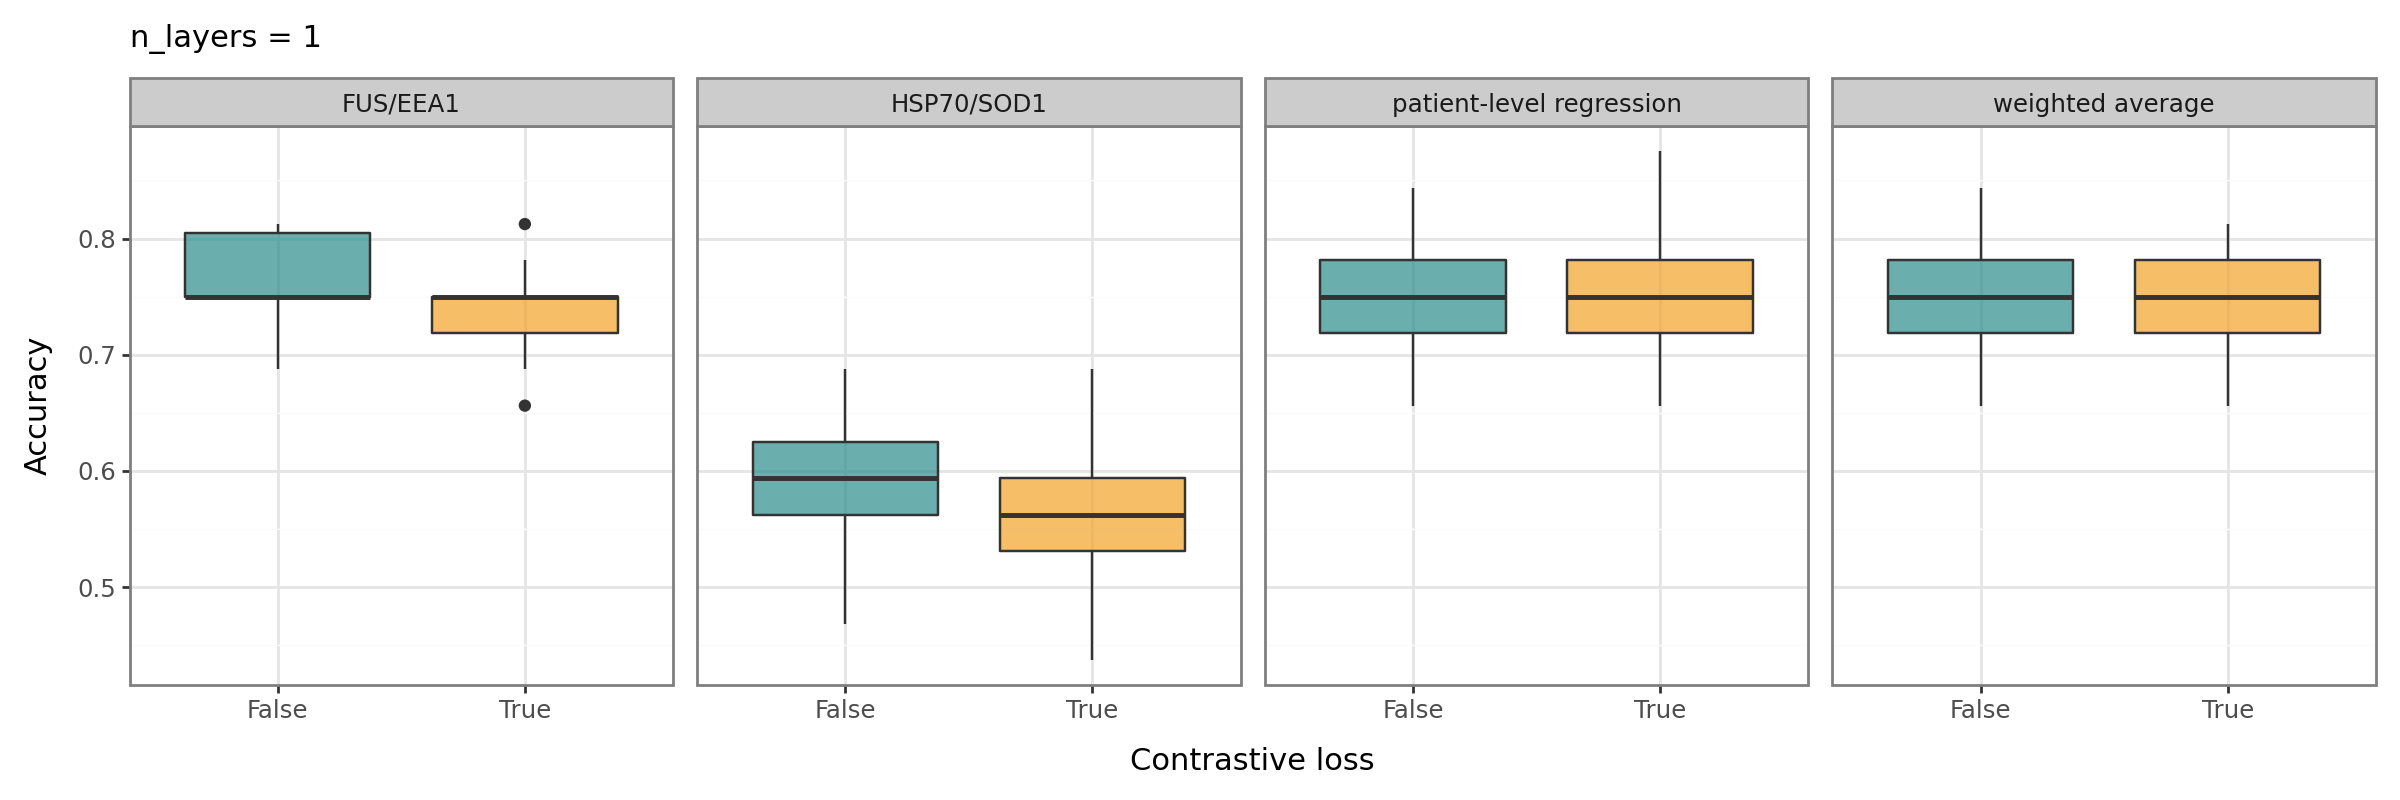

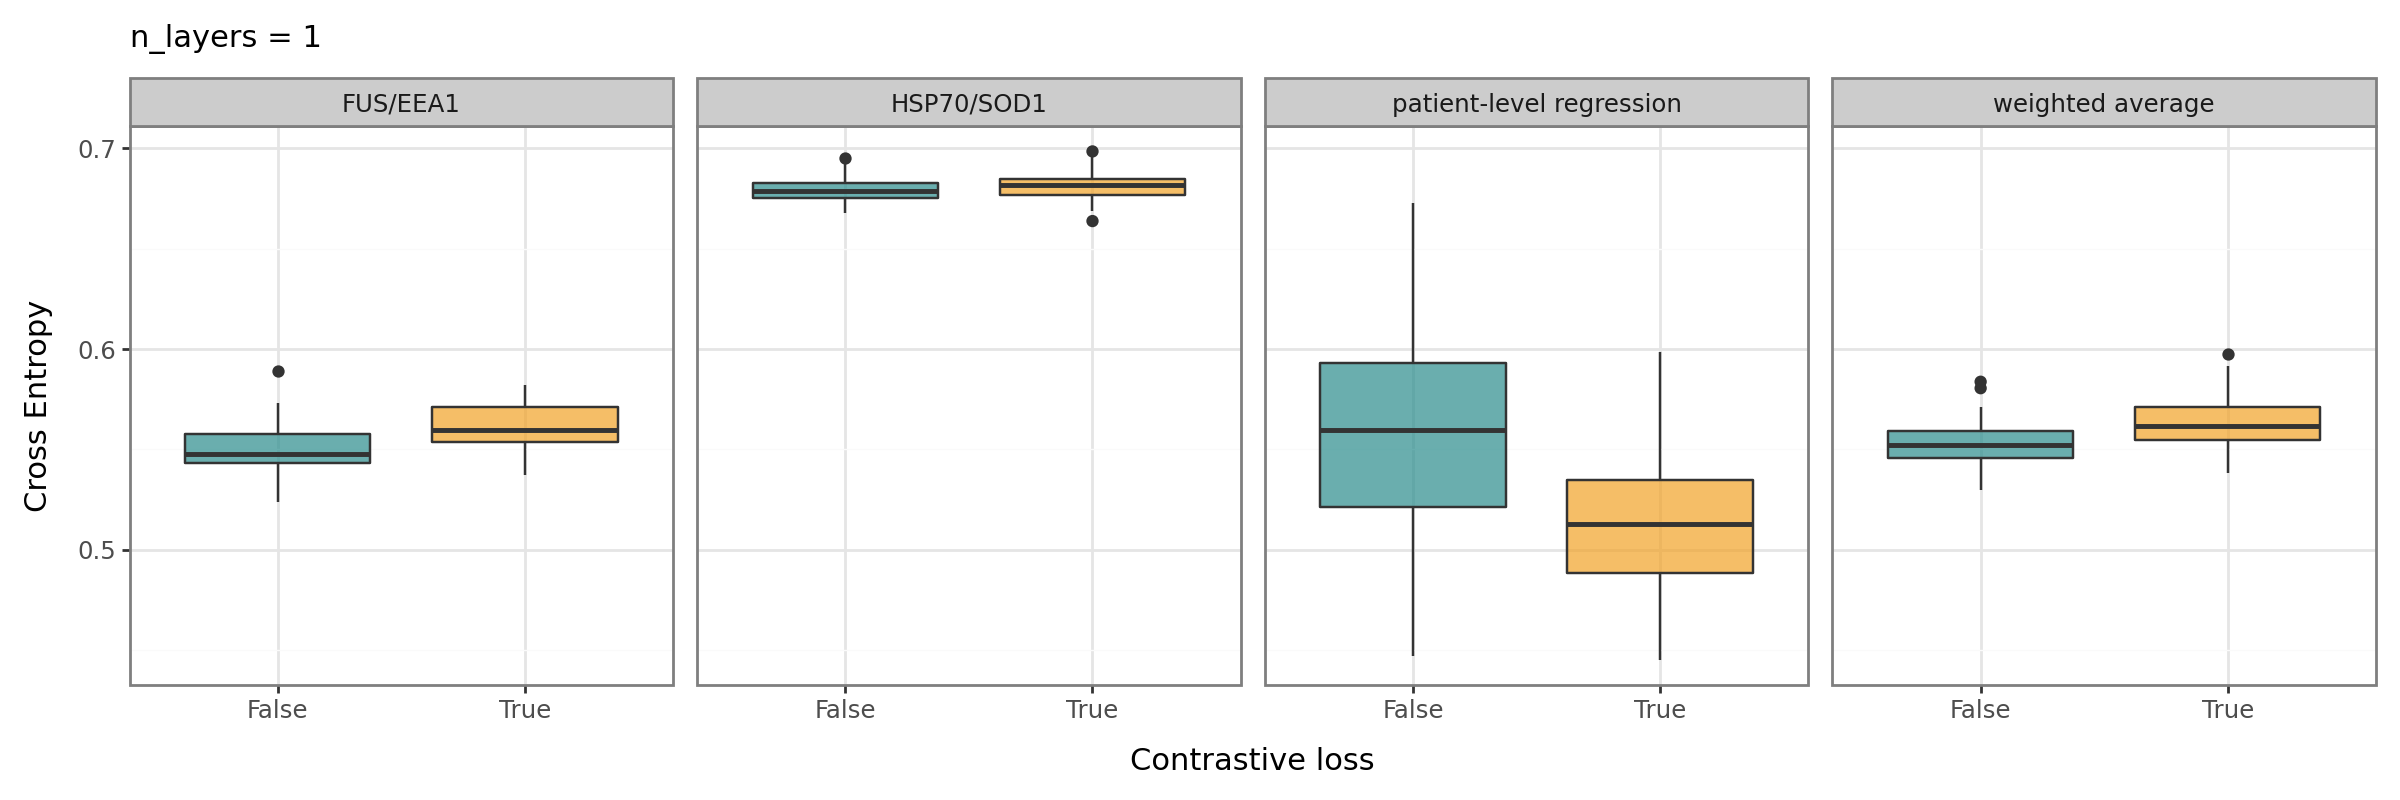

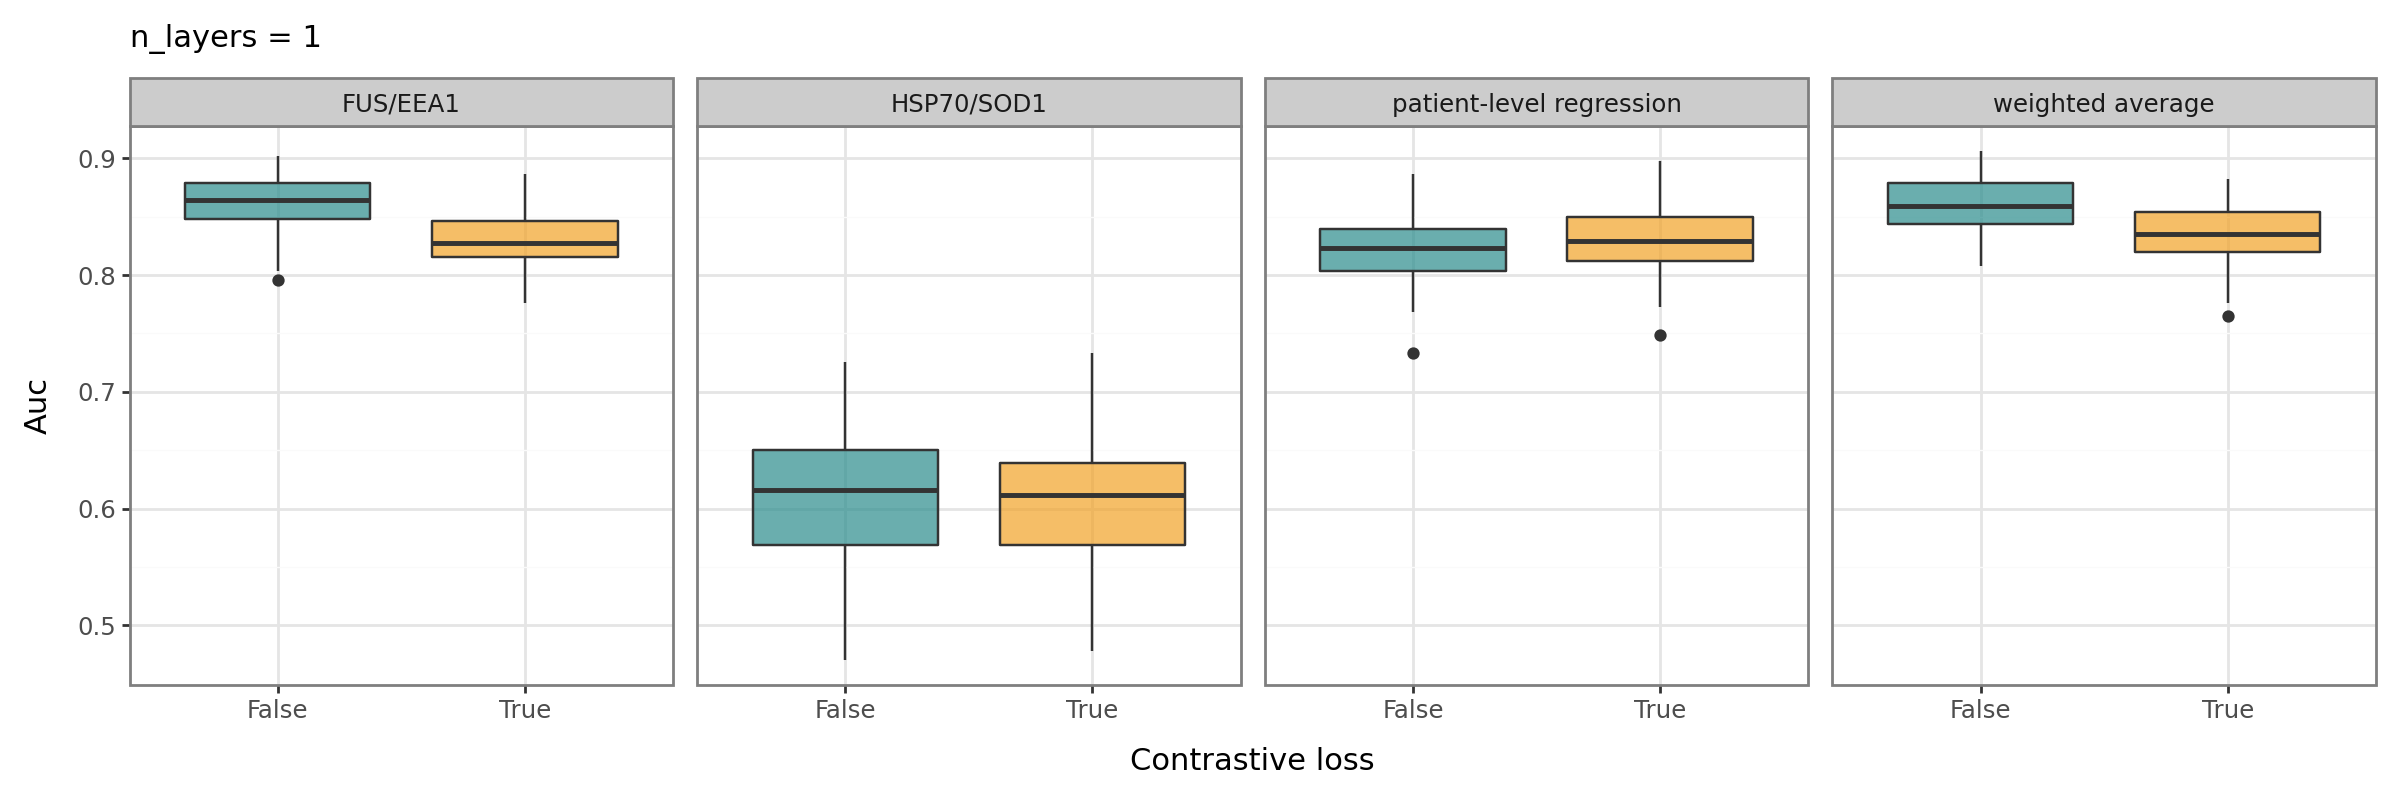

In [9]:
## Performance by Embedding Dimension (d_model)

if grid_results is not None:
    # Create plots comparing metrics by d_model (filtered to n_layers = 1)
    for metric in ['accuracy', 'cross_entropy', 'auc']:
        metric_data = grid_results[(grid_results['metric'] == metric) & (grid_results['n_layers'] == 1) & (grid_results['d_model'] == 16)]
        
        p = (
            ggplot(metric_data, aes(x='factor(use_contrastive_loss)', y='value', fill='factor(use_contrastive_loss)')) +
            geom_boxplot(alpha=0.7) +
            facet_wrap('~group', nrow=1) +
            labs(x='Contrastive loss', y=metric.replace('_', ' ').title(), fill='use_contrastive_loss',
                 subtitle='n_layers = 1') +
            scale_fill_manual(values=['#298c8c', '#f1a226']) +
            theme_bw() +
            theme(
                axis_text_x=element_text(rotation=0), 
                legend_position="none",
                figure_size=(12, 4)   
            )
        )
        display(p)

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


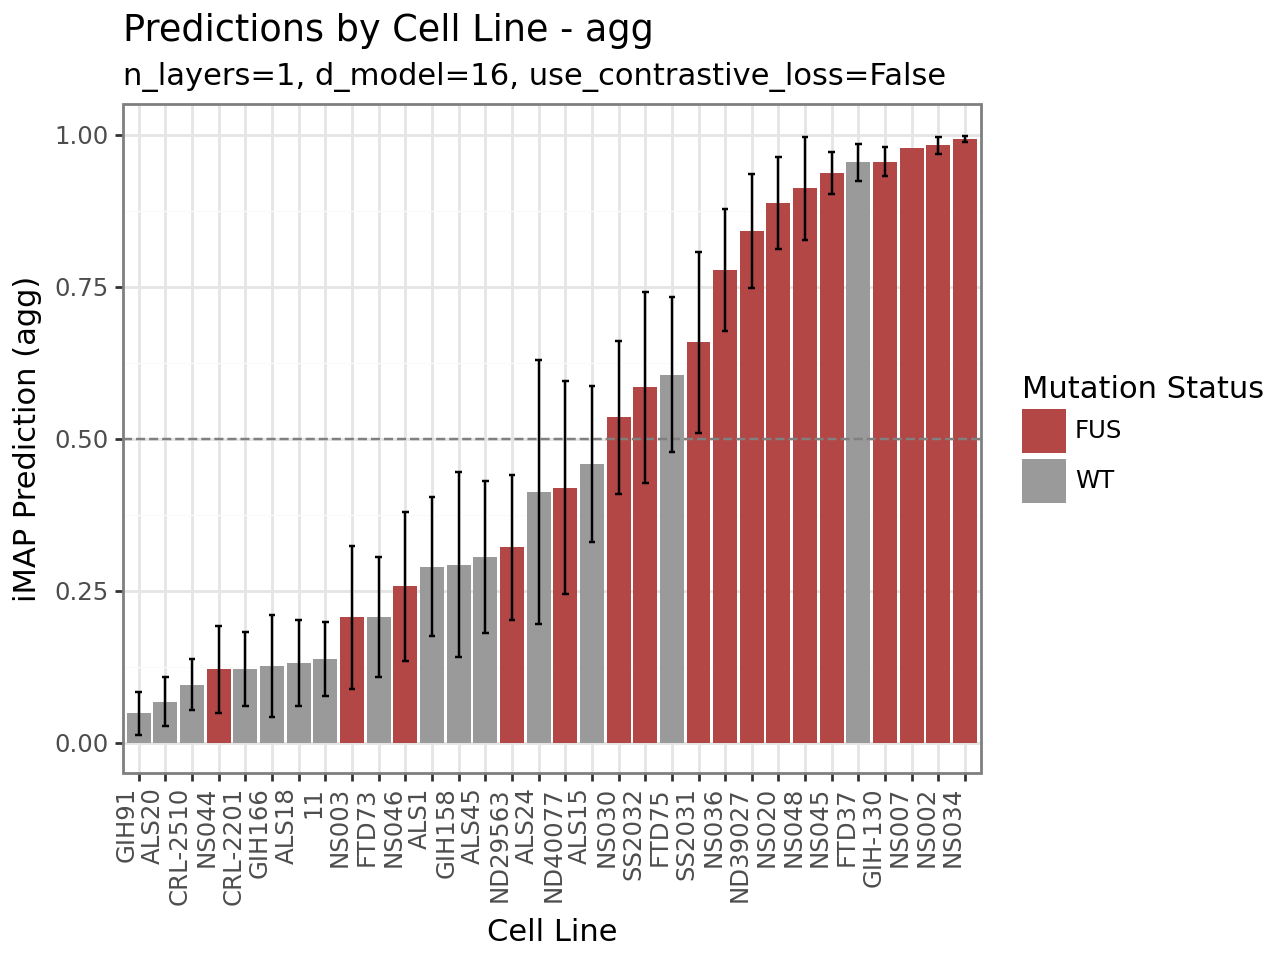

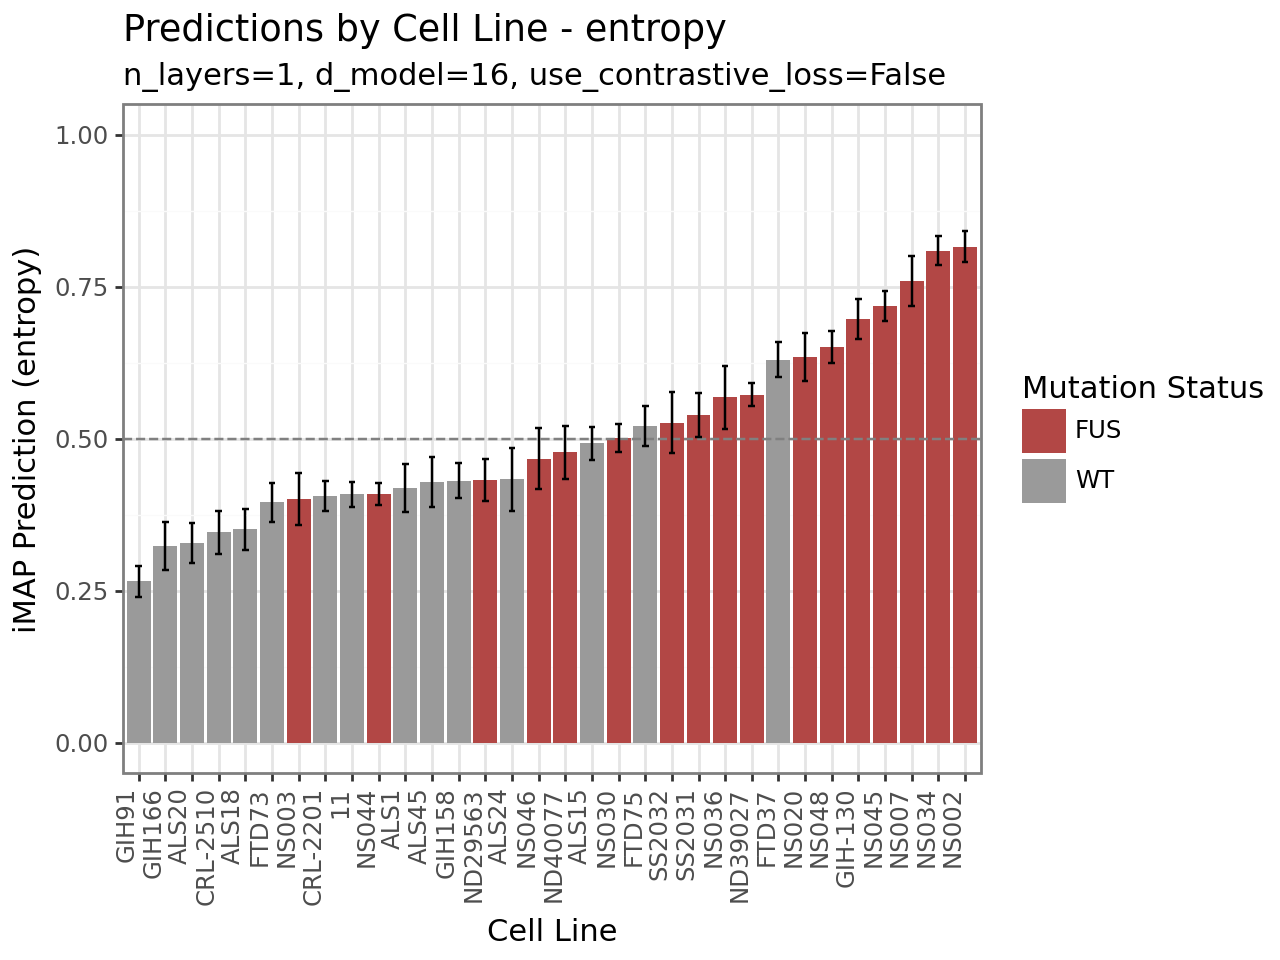

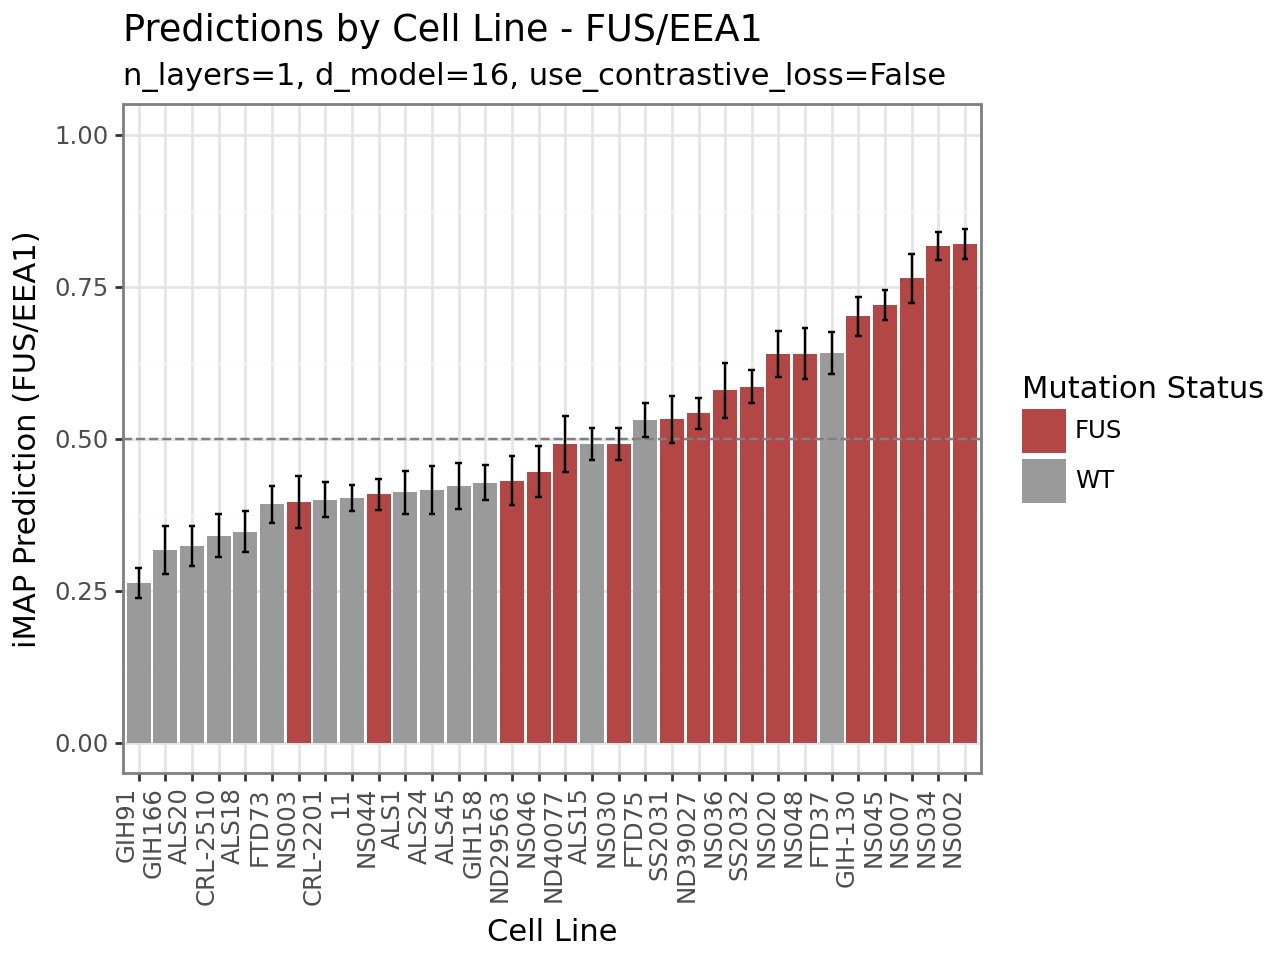

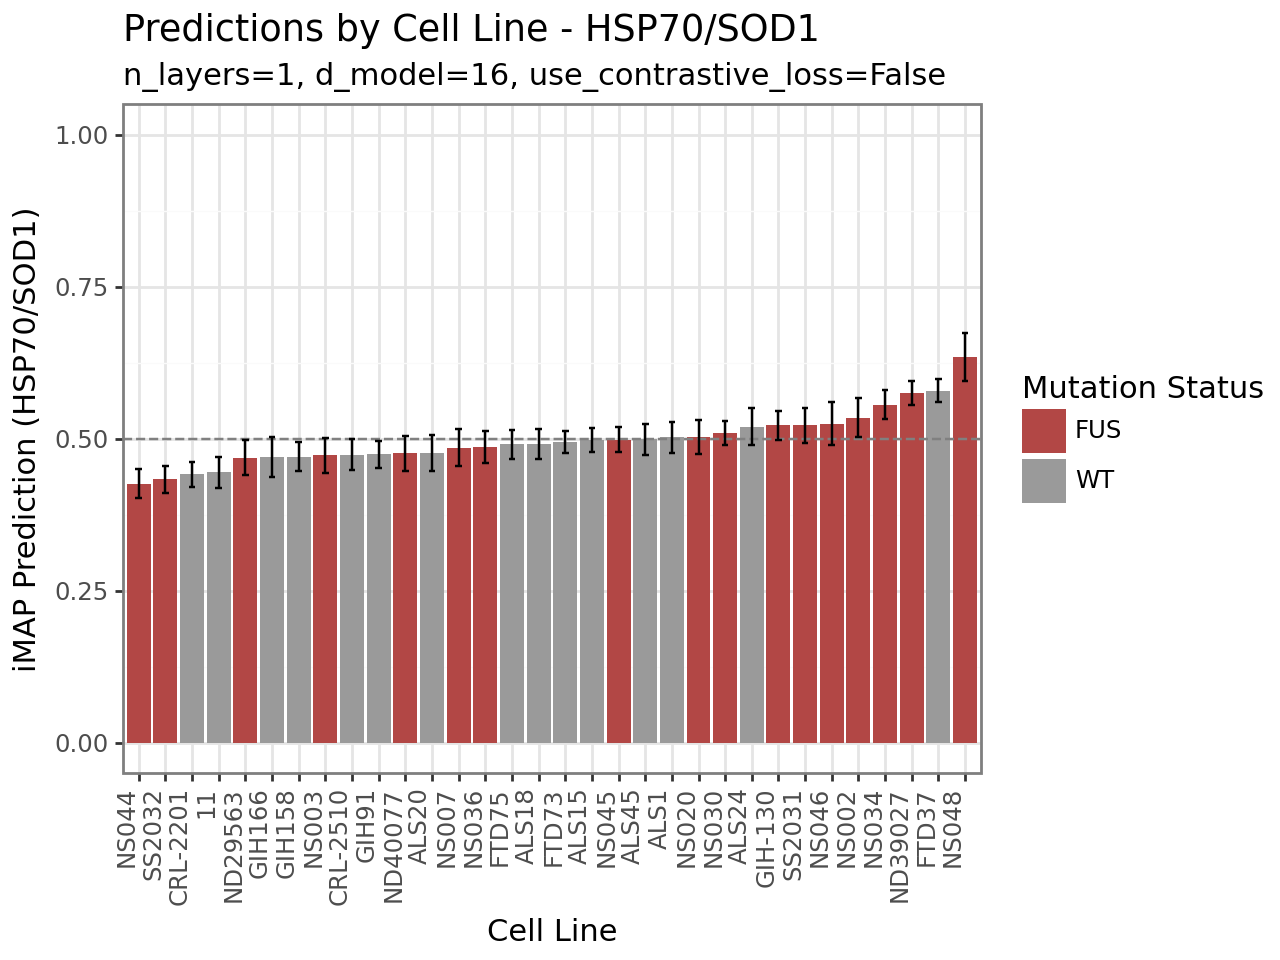

In [11]:
from plotnine import geom_hline, ylim
from maps.figures import PALETTE

if grid_predictions is not None:
    # Define cell line classifications (you may need to adjust these based on your data)
    cell_line_classes = {}
    
    # Try to infer from True labels if available
    if 'True' in grid_predictions.columns:
        for cell_line in grid_predictions['CellLines'].unique():
            cell_line_data = grid_predictions[grid_predictions['CellLines'] == cell_line]
            most_common_class = cell_line_data['True'].mode().iloc[0] if len(cell_line_data['True'].mode()) > 0 else 0
            cell_line_classes[cell_line] = 'FUS' if most_common_class == 1 else 'WT'
    else:
        # Fallback classification (update based on your knowledge)
        for cell_line in grid_predictions['CellLines'].unique():
            cell_line_classes[cell_line] = 'Unknown'
    
    # Filter to specific conditions: n_layers = 1, d_model = 16, use_contrastive_loss = False
    filtered_predictions = grid_predictions[
        (grid_predictions['n_layers'] == 1) & 
        (grid_predictions['d_model'] == 16) & 
        (grid_predictions['use_contrastive_loss'] == False)
    ].copy()
    
    # Calculate mean and standard deviation of predictions by cell line
    groups = ["agg", "entropy"] + ["FUS/EEA1", "HSP70/SOD1"]
    
    for group in groups:
        if f'class_1_{group}' in filtered_predictions.columns:
            # Create summary statistics for predictions
            pred_summary = filtered_predictions.groupby(['CellLines']).agg({
                f'class_1_{group}': ['mean', 'std', 'count']
            }).reset_index()
            
            # Flatten column names
            pred_summary.columns = ['CellLines', 'mean_pred', 'std_pred', 'count']
            
            # Add cell line classification
            pred_summary['cell_class'] = pred_summary['CellLines'].map(cell_line_classes)
            
            # Order cell lines by average prediction value
            cell_order = pred_summary.sort_values('mean_pred')['CellLines'].tolist()
            pred_summary['CellLines'] = pd.Categorical(pred_summary['CellLines'], categories=cell_order, ordered=True)
            
            # Create plot colored by mutation status
            p = (
                ggplot(pred_summary, aes(x='CellLines', y='mean_pred', fill='cell_class')) +
                geom_bar(stat='identity') +
                geom_hline(yintercept=0.5, linetype='dashed', color='grey') +
                geom_errorbar(aes(ymin='mean_pred - std_pred', ymax='mean_pred + std_pred'), 
                             width=0.25, color='black') +
                labs(x='Cell Line', y=f'iMAP Prediction ({group})', fill='Mutation Status',
                     title=f'Predictions by Cell Line - {group}',
                     subtitle='n_layers=1, d_model=16, use_contrastive_loss=False') +
                scale_fill_manual(values=PALETTE) +
                theme_bw() +
                ylim(0, 1) +
                theme(axis_text_x=element_text(rotation=90, hjust=1))
            )
            display(p)